Thinkful Bootcamp Course

Author: Ian Heaton

Email: iheaton@gmail.com

Mentor: Nemanja Radojkovic

Date: 2017/05/28


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import scipy

from time import time
from IPython.display import display
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.preprocessing import normalize

%matplotlib inline

sb.set_style('darkgrid')
my_dpi = 96

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Boston Marathon


## Question:

What can Unsupervised Clustering tell us about the 2014 Boston Marathon?

### Data:

Boston Marathon Raw Data

Repository contains all of the data on the Boston Marathon available from baa.org. Race results data can be found at this [website](https://github.com/llimllib/bostonmarathon/tree/master/results). Data used in the notebook is from 2014.

### Context:

### Content:

+ 10K : Time in minutes and seconds of runner at 10K point of the 42.195K race.
+ Name : Name of Participant in race.
+ Divison : ?
+ 25K :  Time in minutes and seconds of runner at 25K point of the 42.195K race.
+ Gender : Sex of participant.
+ Age : Age in years of participant at the time of race.
+ Official : Finishing time of participant in minutes and seconds.
+ Bib : Bib number which are a tool for race directors to tell these thousands of runners apart and to simplify the seemingly impossible task of getting a time for each and every one of these runners.
+ Gender Divison : ? (Appears to have the same value as the Divison feature for an observation).
+ CTZ (Citizenship) : Only available if different from country of residence.
+ 35K : Time in minutes and seconds of runner at 35K point of the 42.195K race.
+ Overall : Overall finish position.
+ Pace : Average kilometer time in minutes and seconds.
+ State : United States state abbreviation, only available if runner’s country of origin is the US.
+ 30K : Time in minutes and seconds of runner at 35K point of the 42.195K race.
+ 5K : Time in minutes and seconds of runner at 5K point of the 42.195K race.
+ Half : Time in minutes and seconds of runner at half way point (21.0975) of the 42.195K race.
+ 20K : Time in minutes and seconds of runner at 20K point of the 42.195K race.
+ Country : Participant country of origin.
+ City : City of Residence of participant.
+ 40K : Time in minutes and seconds of runner at 40K point of the 42.195K race.

In [23]:
# Read CSV containing text data
data_file = '/media/ianh/space/ThinkfulData/BostonMarathon/2014_results.csv'
marathon = pd.read_csv(data_file)
print("\nNumbr of Observations : %d\n" % (marathon.shape[0]))
print("Number of Features : %d" % (marathon.shape[1]))


Numbr of Observations : 31984

Number of Features : 21


### Preprocessing and exploratory data analysis

In [24]:
# Check for missing data
print("%s\n" % (marathon.isnull().sum()))

# Lets ensure that all columns are of the expected type object and int (or float)
print("\n%s\n" % (marathon.dtypes))

10k              0
name             0
division         0
25k              0
gender           0
age              0
official         0
bib              0
genderdiv        0
ctz          30740
35k              0
overall          0
pace             0
state         2576
30k              0
5k               0
half             0
20k              0
country          0
city             1
40k              0
dtype: int64


10k           object
name          object
division       int64
25k           object
gender        object
age            int64
official     float64
bib           object
genderdiv      int64
ctz           object
35k           object
overall        int64
pace         float64
state         object
30k           object
5k            object
half          object
20k           object
country       object
city          object
40k           object
dtype: object



First some of the text features will be dropped from the Data frame. These features can not be used in Cluster analysis without being transformed.
These include name, bib, ctz, and state. In addition, the features state and ctz have too many null values to be of use. Second, all time related features will be converted to float so that they may be  used in the analysis. 

In [25]:
# convert string (object) features to floats
marathon = marathon.replace(to_replace='-', value='')
marathon['10k'] = marathon['10k'].convert_objects(convert_numeric=True)
marathon['25k'] = marathon['25k'].convert_objects(convert_numeric=True)
marathon['30k'] = marathon['30k'].convert_objects(convert_numeric=True)
marathon['35k'] = marathon['35k'].convert_objects(convert_numeric=True)
marathon['5k'] = marathon['5k'].convert_objects(convert_numeric=True)
marathon['20k'] = marathon['20k'].convert_objects(convert_numeric=True)
marathon['40k'] = marathon['40k'].convert_objects(convert_numeric=True)
marathon['half'] = marathon['half'].convert_objects(convert_numeric=True)

# drop features name, bib etc.
features_to_drop = ['name', 'bib', 'ctz', 'state', 'genderdiv']
marathon = marathon.drop(features_to_drop, axis=1)

# temp drop of features to speed up analysis
# features_to_drop = ['30k']
# marathon = marathon.drop(features_to_drop, axis=1)

Next, we map categorical data to integers.  The features gender and country could provide some useful information to the clustering algorithm and should be retained. The city feature will be dropped as there are too many unique values making a mapping from categorical to integer unwieldy. 

In [26]:
# map gender values to integer
gender_mapping = {'M': 1, 'F': 2}
marathon.gender = marathon.gender.map(gender_mapping)

# map country names to integers
country_mapping = {'JPN':1, 'KEN':2, 'RSA':3, 'ETH':4, 'SUI':5, 'USA':6, 'FRA':7, 'CAN':8, 'ESP':9,
                   'POL':10, 'RUS':11, 'BLR':12, 'MAR':13, 'UKR':14, 'BRA':15, 'THA':16, 'CHN':17, 'ITA':18,
                   'GER': 19, 'GBR':20, 'AUS':21, 'SWE':22, 'GRE':23, 'SLO':24, 'IRL':25, 'KOR':26, 'ARG':27,
                   'COL':28, 'NED':29, 'ISR':30, 'CZE':31, 'NOR':32, 'AUT':33, 'CRC':34, 'MEX':35, 'GUA':36,
                   'SIN':37, 'DEN':38, 'HUN':39, 'BEL':40, 'FIN':41, 'CHI':42, 'ISL':43, 'VEN':44, 'DOM':45,
                   'PER':46, 'HKG':47, 'SVK':48, 'NZL':49, 'TPE':50, 'PHI':51, 'CAY':52, 'POR':53, 'UAE':54,
                   'IND':55, 'PAN':56, 'ROU':57, 'LUX':58, 'ESA':59, 'TRI':60, 'MAS':61, 'VGB':62, 'EGY':63,
                   'BRN':64, 'EST':65, 'ECU':66, 'LIE':67, 'TUR':68, 'BOL':69, 'BAR':70, 'URU':71, 'QAT':72,
                   'INA':73, 'BER':74, 'TAN':75, 'BAH':76, 'CRO':77, 'ZIM':78}

marathon.country = marathon.country.map(country_mapping)

# drop city from dataframe
marathon = marathon.drop('city', axis=1)
marathon.head()

,10k,division,25k,gender,age,official,35k,overall,pace,30k,5k,half,20k,country,40k
0,17.37,8,47.67,1,47,85.25,71.40,8,3.27,59.18,8.02,39.72,37.65,1,80.43
1,32.58,1,82.43,2,33,138.95,116.37,21,5.30,99.33,16.22,69.47,65.83,2,132.10
2,16.62,1,45.80,1,41,80.60,67.42,1,3.08,56.45,7.75,38.03,36.10,3,76.10
3,32.57,3,82.43,2,24,140.58,116.37,27,5.37,99.33,16.20,69.47,65.83,4,132.95
4,17.12,2,46.37,1,40,81.23,67.83,2,3.10,57.03,8.02,38.60,36.58,1,76.72


Lastly, we normalize the data or rescale the features to a range of [0, 1] and drop any observations that have Nan values.


Numbr of Observations Remaining : 31649


Numbr of Features Remaining : 15



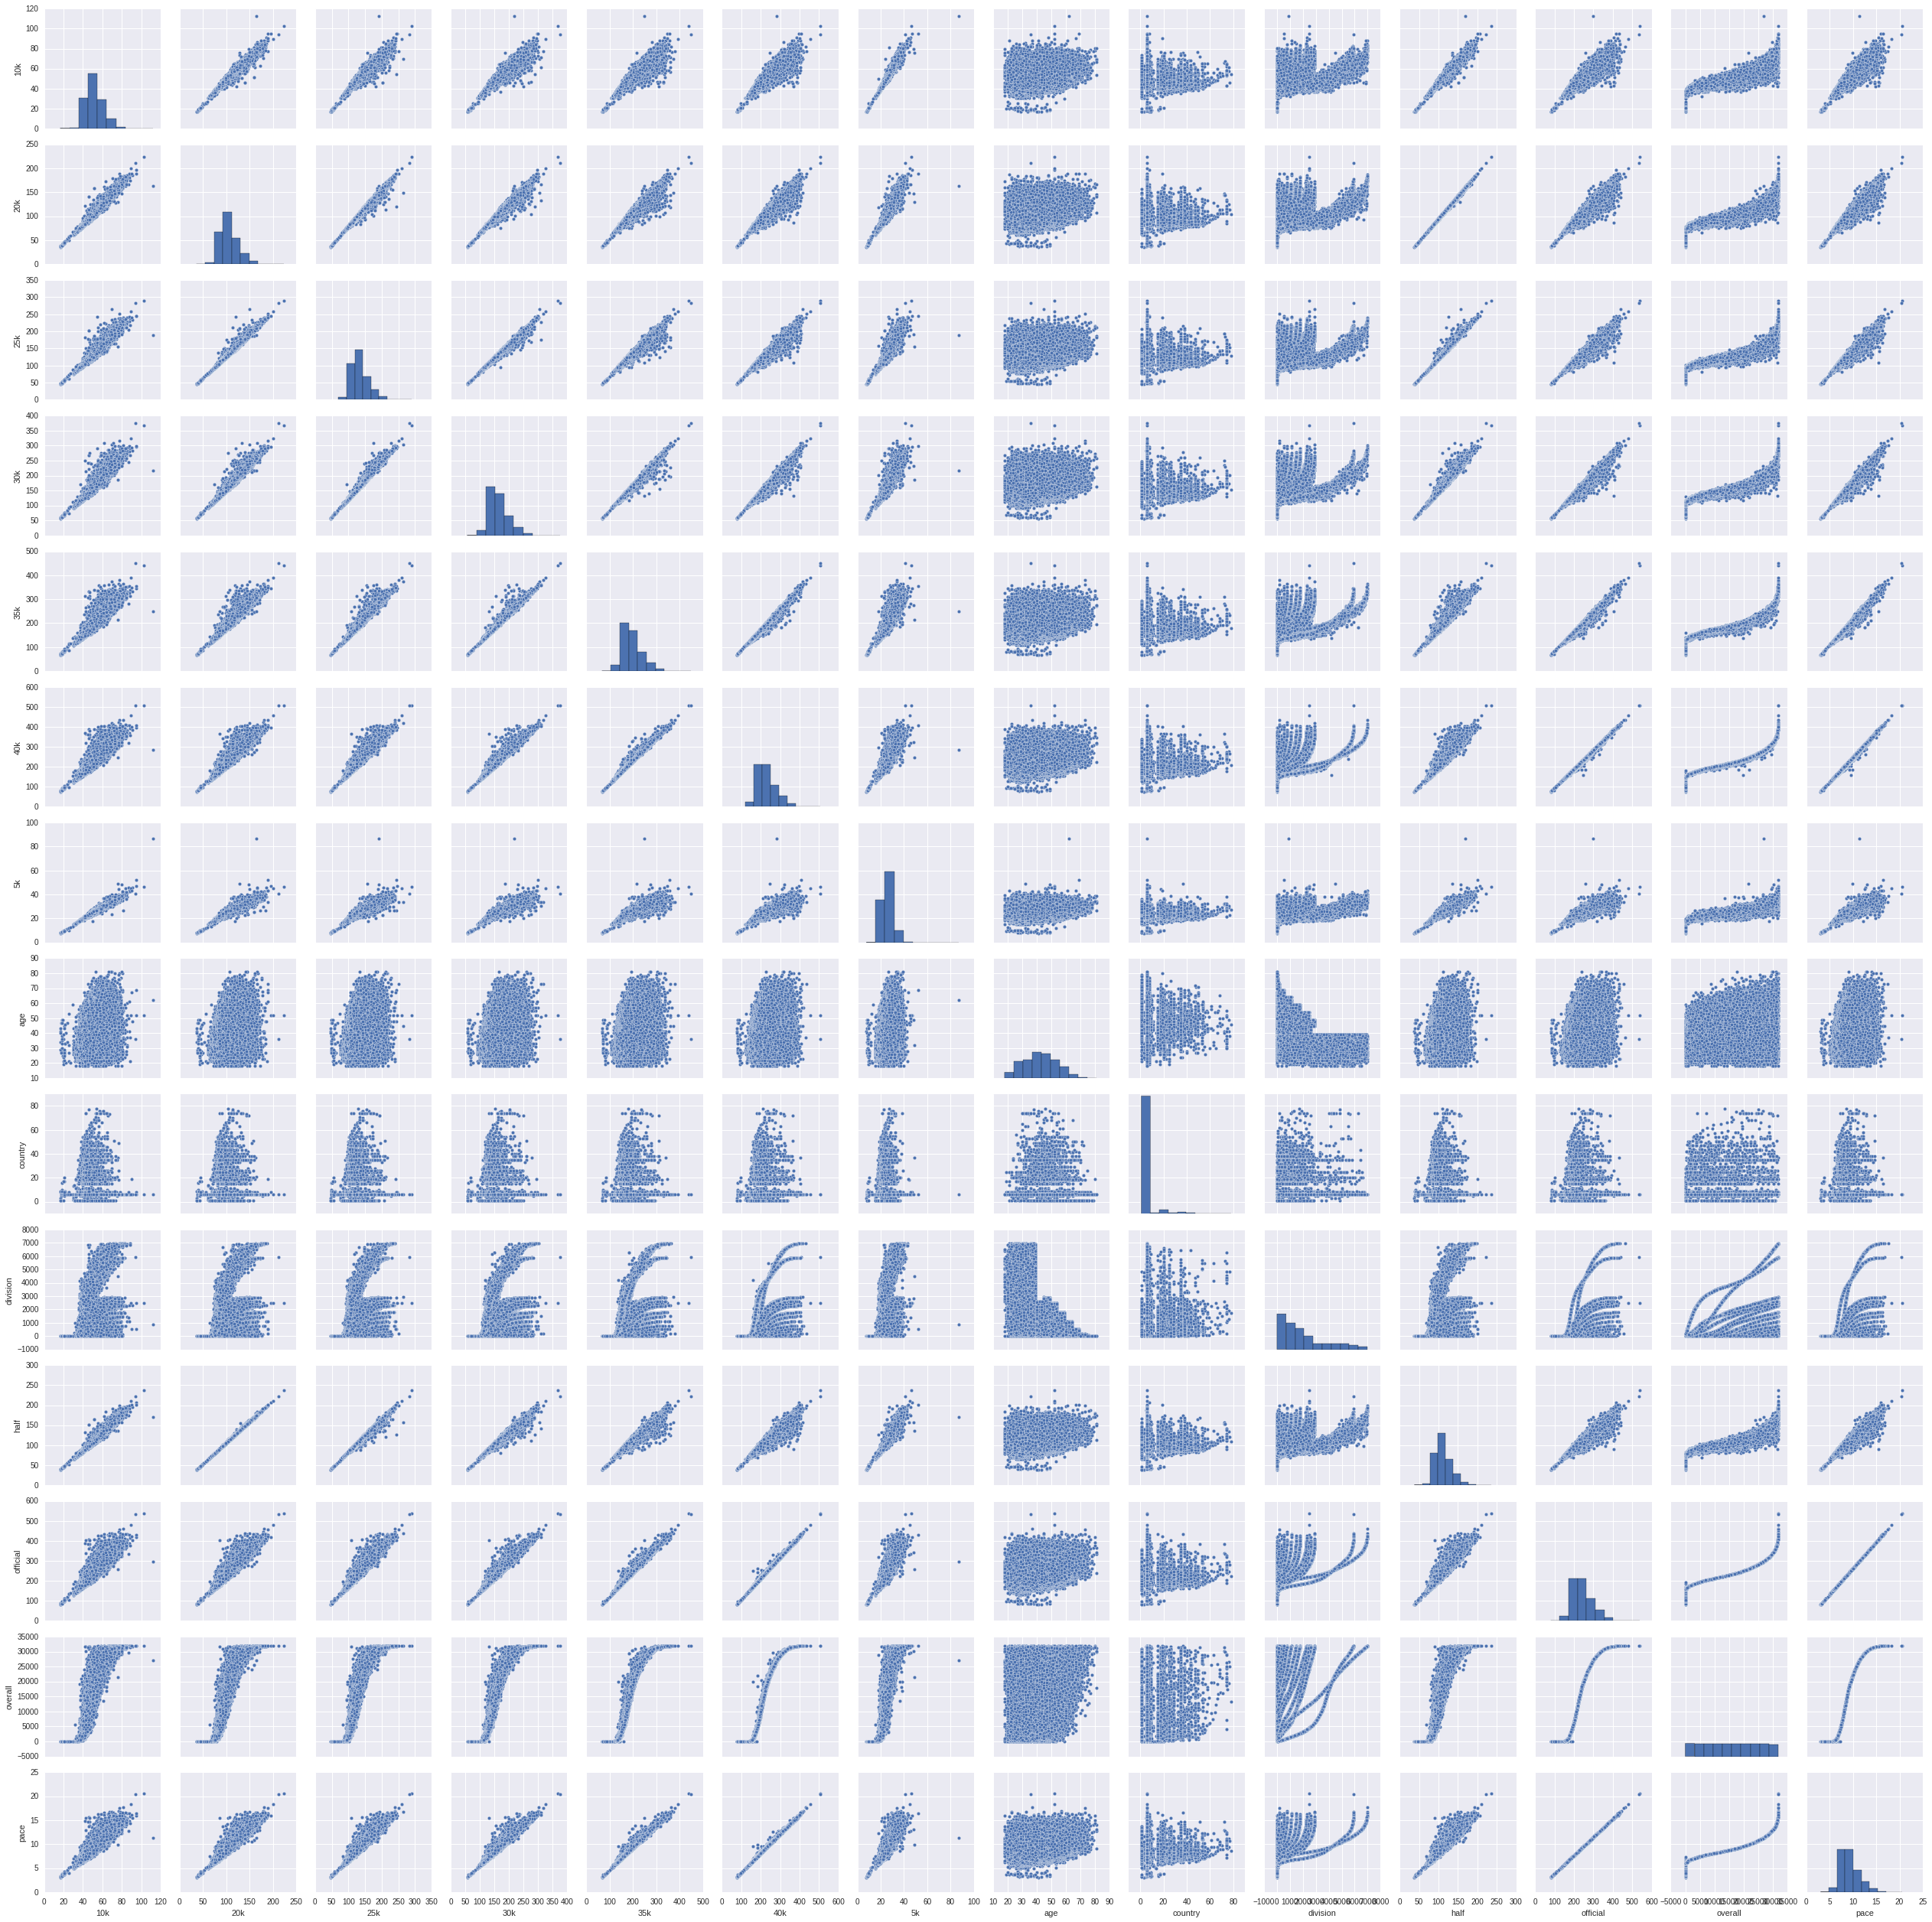

In [27]:
marathon = marathon.dropna()

exclude = ['gender']
__ = sb.pairplot(marathon.ix[:,marathon.columns.difference(exclude)])
print("\nNumbr of Observations Remaining : %d\n" % (marathon.shape[0]))
print("\nNumbr of Features Remaining : %d\n" % (marathon.shape[1]))

mms = MinMaxScaler()
X = normalize(marathon)

## Mean-shift Model

The shape of Normalized Data rows : 31649 and columns 15
Number of estimated clusters: 4
The Silhouette Coefficient: 0.760


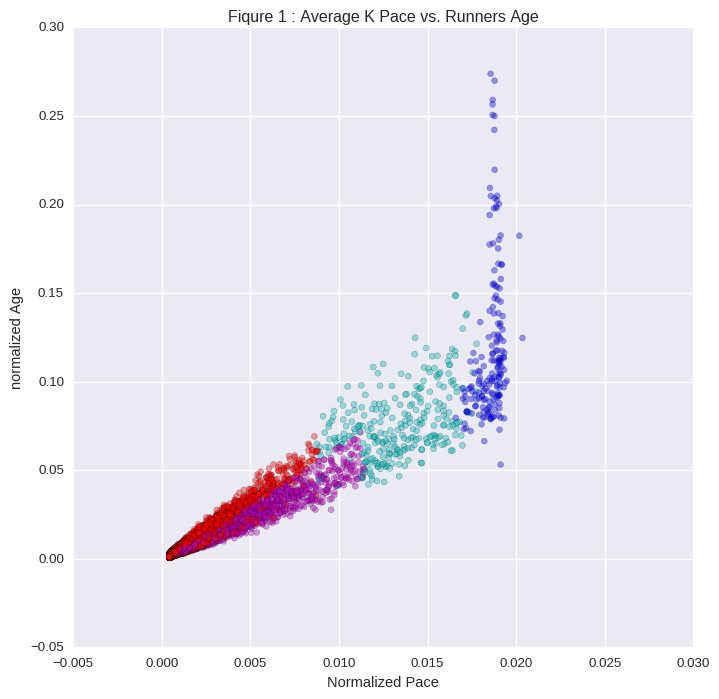

In [28]:
print('The shape of Normalized Data rows : %d and columns %d' % (X.shape[0], X.shape[1]))
bandwidth = estimate_bandwidth(X, quantile=0.4)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)

# Extract cluster assignments for each data point.
labels = ms.labels_

LABEL_COLOR_MAP = {0 : 'r', 1 : 'm', 2 : 'b', 3: 'c'}

label_color = [LABEL_COLOR_MAP[l] for l in labels]
# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))
silhouette = metrics.silhouette_score(X, ms.labels_, metric='euclidean', sample_size=15000)
print("The Silhouette Coefficient: {:.3f}".format(silhouette))

# Plot of Pace vs. Runner's Age
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
plt.title('Fiqure 1 : Average K Pace vs. Runners Age')
plt.xlabel('Normalized Pace')
plt.ylabel('normalized Age')
__ = plt.scatter(X[:, 8], X[:, 4], c=label_color, alpha=0.4)

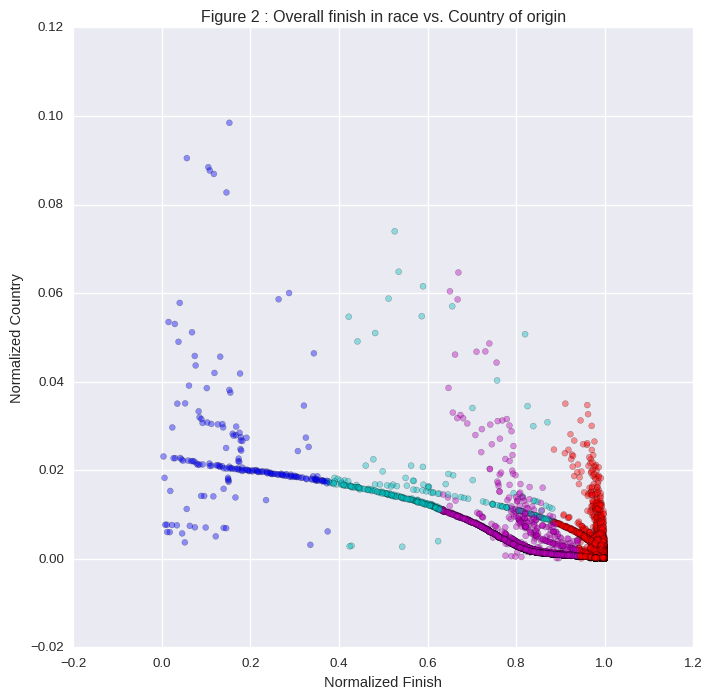

In [10]:
# Plot of overall place in race vs. Country of origin
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
plt.title('Figure 2 : Overall finish in race vs. Country of origin')
plt.xlabel('Normalized Finish')
plt.ylabel('Normalized Country')
__ = plt.scatter(X[:, 7], X[:, 13], c=label_color, alpha=0.4)

[  5.74294160e-03   7.11514265e-03   6.09648064e-03 ...,   7.80111725e-05
   7.12055604e-05   6.70395708e-05]


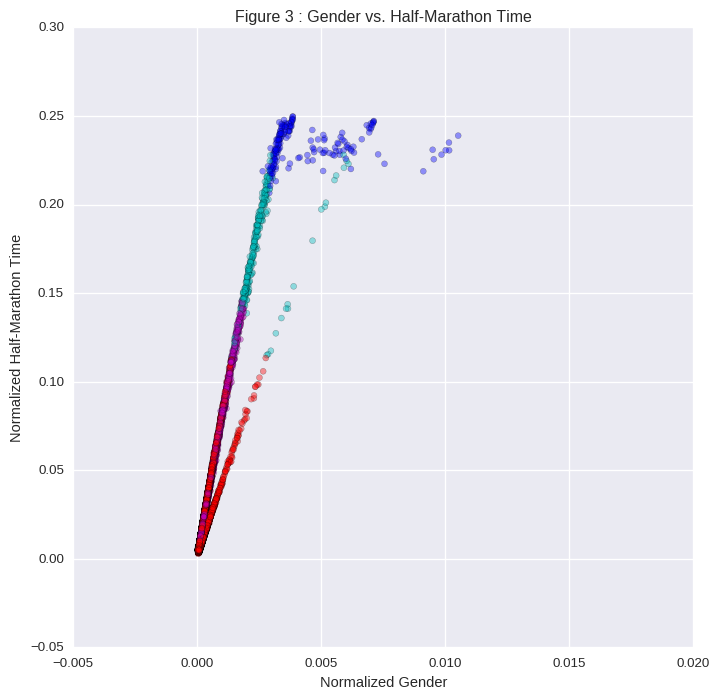

In [13]:
# Plot of Gender vs. Half-Marathon time
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
print(X[:, 3])
plt.title('Figure 3 : Gender vs. Half-Marathon Time')
plt.xlabel('Normalized Gender')
plt.ylabel('Normalized Half-Marathon Time')
__ = plt.scatter(X[:, 3], X[:, 11], c=label_color, alpha=0.4)

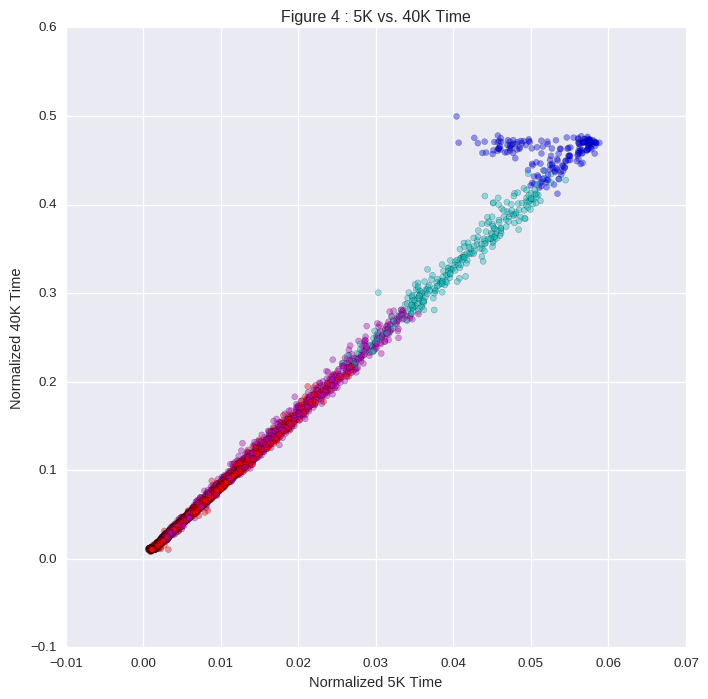

In [12]:
# Plot of 5 K vs. 40K time
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
plt.title('Figure 4 : 5K vs. 40K Time')
plt.xlabel('Normalized 5K Time')
plt.ylabel('Normalized 40K Time')
__ = plt.scatter(X[:, 10], X[:, 14], c=label_color, alpha=0.4)

## Discussion

There different clustering models were run on the Marathon results. Mean-Shift clustering was favored over K-Means clustering.  With Mean-Shift the number of clusters sought does not have to be specified.  The point of this challenge was exploratory, find new associations within the racing results.  The Mean Shift model produced a higher Silhouette coefficient value than the K-Means model, 0.761 compared to a value of 0.560.  Spectral Clustering used a little over 9GiB of memory and eventually terminated with a memory error. My virtual machine has 2 cores and 11 GiB of memory allocated and this was not enough to complete Spectral cluster to completion. 

The Mean-Shift model found 4 Clusters. Those graphs that depict two streams of data points are believed to be representing male and female. The assigning of clusters does not appear to be specific to the sex of the runner.  Figure 1 shows the plotting of Age and average kilometer pace.  All values shown on the axis of plots are normalized.   Those groups depicted by the colors purple and red have the fastest pace and appear to be younger in age. Interesting that the cone of data points is stratified by red then purple while the cyan and blue clusters are very district in their positioning on the plot. 

